# Analyzing Training, Validation, and Testing Sets

Investigates the charge from the dataset for HKHybrid geomotry.

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from exploratory_data_analysis_utils import *

# Load Data From H5

In [4]:
# Import test events from h5 file
data_path = "/scratch/jgao/data/HKHybrid/HKHybrid_e-mu-_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_6Mevts.hdf5"
# data_path = "/scratch/jgao/data/all.hdf5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt_20    = data_file["hit_pmt_20"]
hdf5_hit_time_20   = data_file["hit_time_20"]
hdf5_hit_charge_20 = data_file["hit_charge_20"]
hdf5_hit_pmt_3    = data_file["hit_pmt_3"]
hdf5_hit_time_3   = data_file["hit_time_3"]
hdf5_hit_charge_3 = data_file["hit_charge_3"]

hit_pmt_20    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt_20.shape,
                          offset=hdf5_hit_pmt_20.id.get_offset(), dtype=hdf5_hit_pmt_20.dtype)
hit_time_20   = np.memmap(data_path, mode="r", shape=hdf5_hit_time_20.shape,
                          offset=hdf5_hit_time_20.id.get_offset(), dtype=hdf5_hit_time_20.dtype)
hit_charge_20 = np.memmap(data_path, mode="r", shape=hdf5_hit_charge_20.shape,
                          offset=hdf5_hit_charge_20.id.get_offset(), dtype=hdf5_hit_charge_20.dtype)

hit_pmt_3    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt_3.shape,
                          offset=hdf5_hit_pmt_3.id.get_offset(), dtype=hdf5_hit_pmt_3.dtype)
hit_time_3   = np.memmap(data_path, mode="r", shape=hdf5_hit_time_3.shape,
                          offset=hdf5_hit_time_3.id.get_offset(), dtype=hdf5_hit_time_3.dtype)
hit_charge_3 = np.memmap(data_path, mode="r", shape=hdf5_hit_charge_3.shape,
                          offset=hdf5_hit_charge_3.id.get_offset(), dtype=hdf5_hit_charge_3.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index_20', 'event_hits_index_3', 'event_ids', 'hit_charge_20', 'hit_charge_3', 'hit_pmt_20', 'hit_pmt_3', 'hit_time_20', 'hit_time_3', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


# Load Indices

In [5]:
idxs_path = '/scratch/jgao/data/HKHybrid/HKHybrid_e-mu-_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_idxs.npz'
# idxs_path = '/scratch/jgao/data/idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

# compute and save event radii

In [15]:
# compute and save event radii

radii = np.sqrt(positions[:,0,0]**2 + positions[:,0,2]**2)

np.savez('event_radii.npz', radii=radii)


In [6]:
radii_data = np.load('event_radii.npz', allow_pickle=True)

radii = radii_data['radii']

# Get indices associated with each dataset and particle type

In [7]:
train_e_idxs = train_idxs[np.where(labels[train_idxs]==1)[0]]
val_e_idxs   = val_idxs[np.where(labels[val_idxs]==1)[0]]
test_e_idxs  = test_idxs[np.where(labels[test_idxs]==1)[0]]
train_mu_idxs = train_idxs[np.where(labels[train_idxs]==2)[0]]
val_mu_idxs   = val_idxs[np.where(labels[val_idxs]==2)[0]]
test_mu_idxs  = test_idxs[np.where(labels[test_idxs]==2)[0]]

# Initialize Detector Geometry Parameters

In [9]:
# Need to be adapted to HK Hybrid geometry
# FIXME!!!!!!!!!!
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

# mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
# mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

pmt_positions_file = '/scratch/jgao/data//HKHybrid/HKHybrid.geo.npz'
pmt_positions   = np.load(pmt_positions_file)['mpmt_image_positions']  #????

data_size = np.max(pmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

In [8]:
event_hits_index_20 = np.append(data_file["event_hits_index_20"], hdf5_hit_pmt_20.shape[0]).astype(np.int64)
event_hits_index_3  = np.append(data_file["event_hits_index_3"], hdf5_hit_pmt_3.shape[0]).astype(np.int64)

# Distribution of total charge

In [31]:
pbar = ProgressBar(widgets=['Calculating Event Total Charge. Progress: ', Percentage(),
                            ' ', Bar(marker='0',left='[',right=']'), ' ', ETA()],
                   maxval=positions.shape[0])

pbar.start()
total_charge = []
total_charge_20 = []
total_charge_3 = []
for i in range(positions.shape[0]):
    pbar.update(i)
    start_20 = event_hits_index_20[i]
    stop_20  = event_hits_index_20[i + 1]
    charge_20 = hit_charge_20[start_20:stop_20]

    start_3 = event_hits_index_3[i]
    stop_3  = event_hits_index_3[i + 1]
    charge_3 = hit_charge_3[start_3:stop_3]
    
    total_charge.append(np.sum(charge_20)+ np.sum(charge_3))
    total_charge_20.append(np.sum(charge_20))
    total_charge_3.append(np.sum(charge_3))
    
pbar.finish()

np.savez('total_charge.npz',   total_charge=total_charge, total_charge_20=total_charge_20,
         total_charge_3=total_charge_3)

Calculating Event Total Charge. Progress: 100% [0000000000000000] Time: 0:08:17


In [9]:
total_charge_20n3 = np.load('total_charge.npz', allow_pickle=True)['total_charge']
total_charge_20 = np.load('total_charge.npz', allow_pickle=True)['total_charge_20']
total_charge_3 = np.load('total_charge.npz', allow_pickle=True)['total_charge_3']

In [12]:
hdf5_hit_pmt_20.shape[0]

9538263946

In [13]:
hdf5_hit_pmt_3.shape[0]

1928366373

In [14]:
event_hits_index_20[-3:]

array([9538262359, 9538263946, 9538263946])

In [15]:
event_hits_index_3[-3:]

array([1928366037, 1928366373, 1928366373])

# Total Charge

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_da

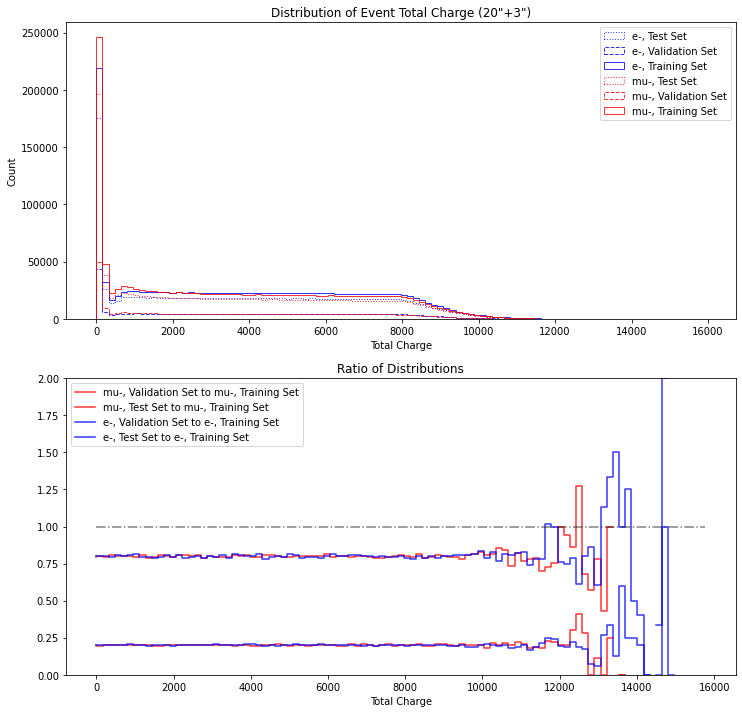

In [13]:
# plot total charge (20"+3") for different datasets
fig = plot_compare_dists([total_charge_20n3[train_mu_idxs],
                          total_charge_20n3[val_mu_idxs],
                          total_charge_20n3[test_mu_idxs],
                          total_charge_20n3[train_e_idxs],
                          total_charge_20n3[val_e_idxs],
                          total_charge_20n3[test_e_idxs]],
                         bins=100, normalized=False,
                         numerator_dist_idxs   = [1,2,4,5],
                         denominator_dist_idxs = [0,0,3,3],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2],title='Distribution of Event Total Charge (20"+3")',
                         colors=['r','r','r','b','b','b'],
                         linestyle=['-','--',':','-','--',':'],
                         xlabel='Total Charge'
                        )

ValueError: Unrecognized linestyle: ['-', '--', ':', '-', '--', ':']

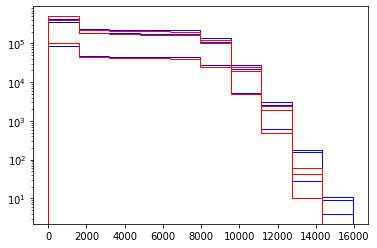

In [14]:
# plot total charge (20"+3") for different datasets [my own code]
plt.hist([total_charge_20n3[train_mu_idxs],
          total_charge_20n3[val_mu_idxs],
          total_charge_20n3[test_mu_idxs],
          total_charge_20n3[train_e_idxs],
          total_charge_20n3[val_e_idxs],
          total_charge_20n3[test_e_idxs]],
         label=['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
         histtype='step', log=True,
         color=['r','r','r','b','b','b'],
         linestyle=['-','--',':','-','--',':'])
plt.plot()

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_dat

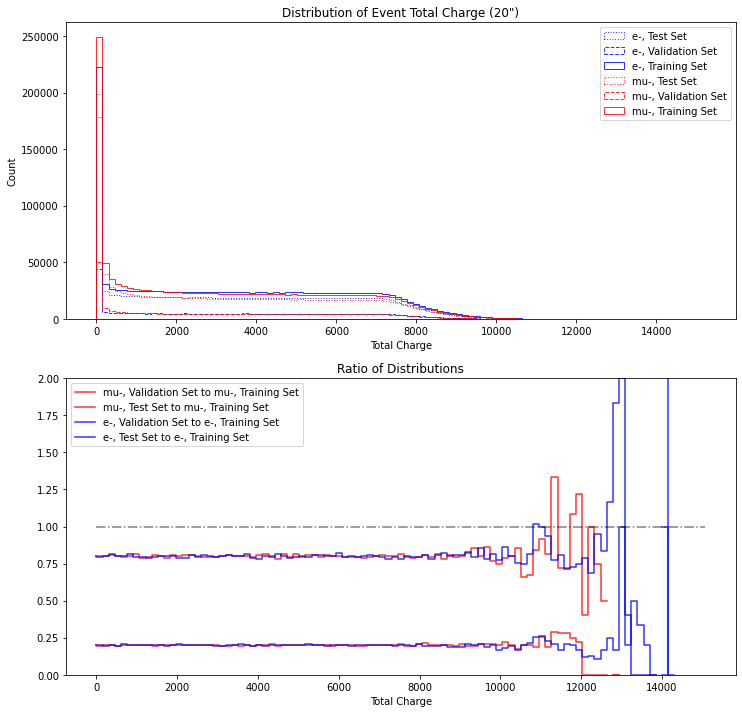

In [15]:
# plot total charge of only 20" for different datasets
fig = plot_compare_dists([total_charge_20[train_mu_idxs],
                          total_charge_20[val_mu_idxs],
                          total_charge_20[test_mu_idxs],
                          total_charge_20[train_e_idxs],
                          total_charge_20[val_e_idxs],
                          total_charge_20[test_e_idxs]],
                         bins=100, normalized=False,
                         numerator_dist_idxs   = [1,2,4,5],
                         denominator_dist_idxs = [0,0,3,3],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2],title='Distribution of Event Total Charge (20")',
                         colors=['r','r','r','b','b','b'],
                         linestyle=['-','--',':','-','--',':'],
                         xlabel='Total Charge',
                        )

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_da

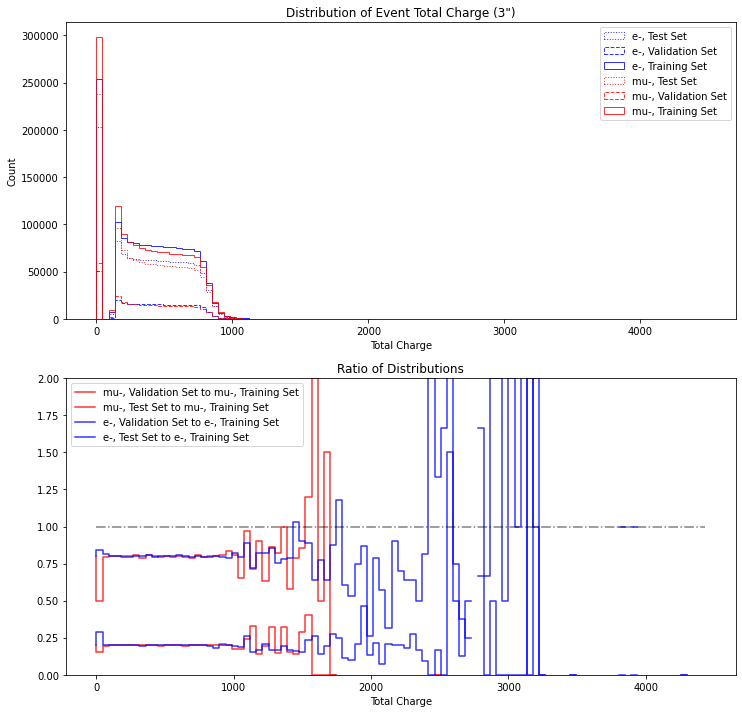

In [16]:
# plot total charge of only 3" for different datasets
fig = plot_compare_dists([total_charge_3[train_mu_idxs],
                          total_charge_3[val_mu_idxs],
                          total_charge_3[test_mu_idxs],
                          total_charge_3[train_e_idxs],
                          total_charge_3[val_e_idxs],
                          total_charge_3[test_e_idxs]],
                         bins=100, normalized=False,
                         numerator_dist_idxs   = [1,2,4,5],
                         denominator_dist_idxs = [0,0,3,3],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2],title='Distribution of Event Total Charge (3")',
                         colors=['r','r','r','b','b','b'],
                         linestyle=['-','--',':','-','--',':'],
                         xlabel='Total Charge'
                        )

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


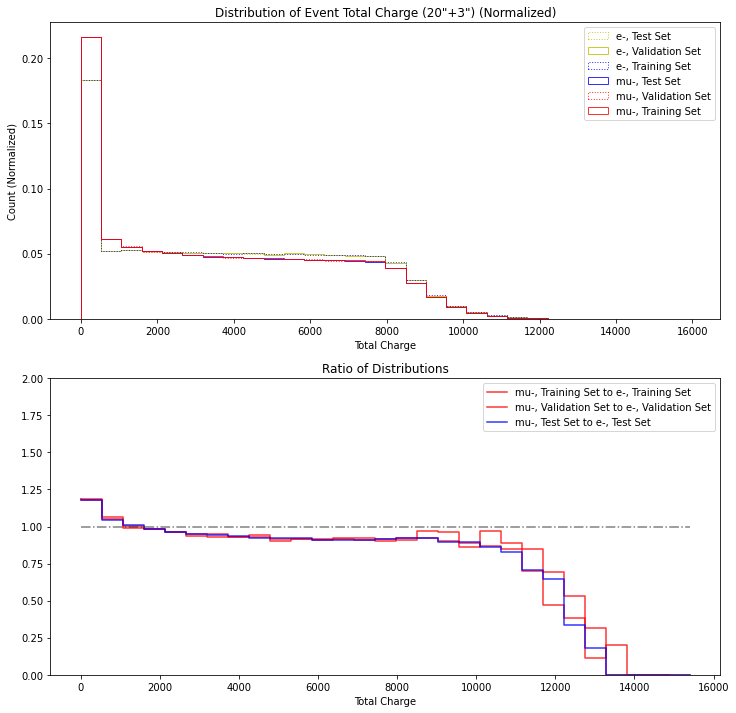

In [38]:
# plot total charge (20"+3") for different particles
fig = plot_compare_dists([total_charge_20n3[train_mu_idxs],
                          total_charge_20n3[val_mu_idxs],
                          total_charge_20n3[test_mu_idxs],
                          total_charge_20n3[train_e_idxs],
                          total_charge_20n3[val_e_idxs],
                          total_charge_20n3[test_e_idxs]],
                         bins=30,
                         numerator_dist_idxs   = [0,1,2],
                         denominator_dist_idxs = [3,4,5],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2], title='Distribution of Event Total Charge (20"+3")',
                         colors=['r','r','b','b','y','y'],
                         linestyle=['-',':','-',':','-',':'],
                         xlabel='Total Charge'
                        )

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


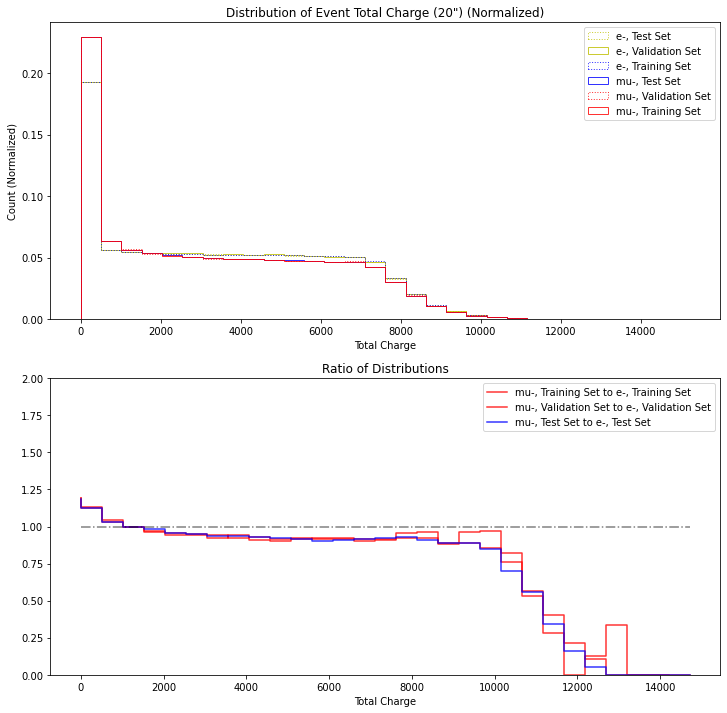

In [39]:
# plot total charge (20") for different particles
fig = plot_compare_dists([total_charge_20[train_mu_idxs],
                          total_charge_20[val_mu_idxs],
                          total_charge_20[test_mu_idxs],
                          total_charge_20[train_e_idxs],
                          total_charge_20[val_e_idxs],
                          total_charge_20[test_e_idxs]],
                         bins=30,
                         numerator_dist_idxs   = [0,1,2],
                         denominator_dist_idxs = [3,4,5],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2], title='Distribution of Event Total Charge (20")',
                         colors=['r','r','b','b','y','y'],
                         linestyle=['-',':','-',':','-',':'],
                         xlabel='Total Charge'
                        )

/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


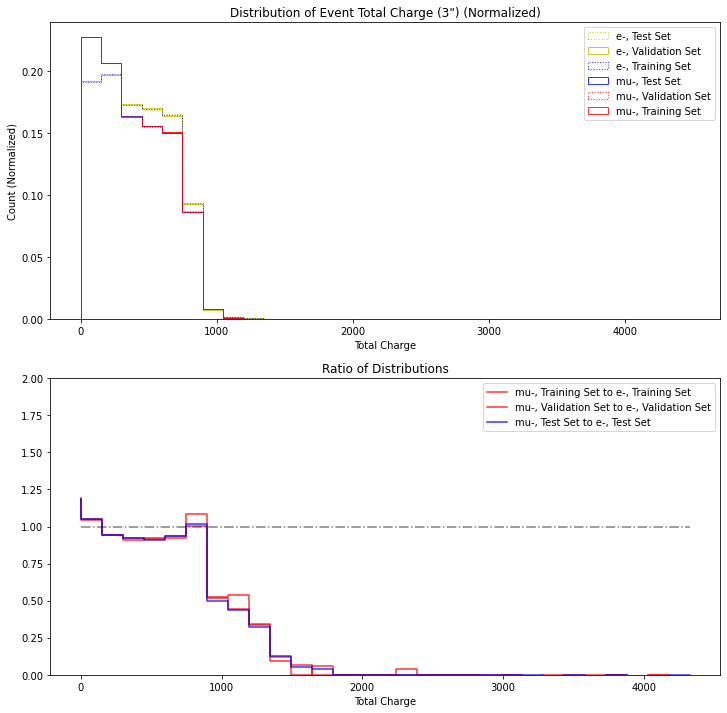

In [40]:
# plot total charge (3") for different particles
fig = plot_compare_dists([total_charge_3[train_mu_idxs],
                          total_charge_3[val_mu_idxs],
                          total_charge_3[test_mu_idxs],
                          total_charge_3[train_e_idxs],
                          total_charge_3[val_e_idxs],
                          total_charge_3[test_e_idxs]],
                         bins=30,
                         numerator_dist_idxs   = [0,1,2],
                         denominator_dist_idxs = [3,4,5],
                         labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                  'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                         ratio_range=[0,2], title='Distribution of Event Total Charge (3")',
                         colors=['r','r','b','b','y','y'],
                         linestyle=['-',':','-',':','-',':'],
                         xlabel='Total Charge'
                        )

# Max Charge

In [9]:
# Max charges include 0
pbar = ProgressBar(widgets=['Calculating Event Max Charge. Progress: ', Percentage(),
                            ' ', Bar(marker='0',left='[',right=']'), ' ', ETA()],
                   maxval=positions.shape[0])

pbar.start()
max_charge_20 = []
max_charge_3 = []
for i in range(positions.shape[0]):
    pbar.update(i)
    
    start_20 = event_hits_index_20[i]
    stop_20  = event_hits_index_20[i + 1]
    charge_20 = hit_charge_20[start_20:stop_20]
#     print(i,start_20, stop_20, charge_20)
    
    start_3 = event_hits_index_3[i]
    stop_3  = event_hits_index_3[i + 1]
    charge_3 = hit_charge_3[start_3:stop_3]
#     print(i,start_3, stop_3)

    max_charge_20.append(np.max(charge_20, initial=0))
    max_charge_3.append(np.max(charge_3, initial=0))
        
pbar.finish()

np.savez('max_charge.npz', max_charge_20=max_charge_20, max_charge_3=max_charge_3)

Calculating Event Max Charge. Progress: 100% [000000000000000000] Time: 0:05:09


In [21]:
# Max charges exclude 0
pbar = ProgressBar(widgets=['Calculating Event Max Charge. Progress: ', Percentage(),
                            ' ', Bar(marker='0',left='[',right=']'), ' ', ETA()],
                   maxval=positions.shape[0])

pbar.start()
max_charge_20 = []
max_charge_3 = []
for i in range(positions.shape[0]):
    pbar.update(i)
    
    start_20 = event_hits_index_20[i]
    stop_20  = event_hits_index_20[i + 1]
    charge_20 = hit_charge_20[start_20:stop_20]
    
    start_3 = event_hits_index_3[i]
    stop_3  = event_hits_index_3[i + 1]
    charge_3 = hit_charge_3[start_3:stop_3]

    if len(charge_20) > 0:
        max_charge_20.append(np.max(charge_20))
    if len(charge_3) > 0:
        max_charge_3.append(np.max(charge_3))
        
pbar.finish()

np.savez('max_charge_without_0.npz', max_charge_20=max_charge_20, max_charge_3=max_charge_3)

Calculating Event Max Charge. Progress: 100% [000000000000000000] Time: 0:05:12


In [24]:
max_charge_20 = np.load('max_charge.npz', allow_pickle=True)['max_charge_20']
max_charge_3 = np.load('max_charge.npz', allow_pickle=True)['max_charge_3']

In [10]:
max_charge_without_0_20 = np.load('max_charge_without_0.npz', allow_pickle=True)['max_charge_20']
max_charge_without_0_3 = np.load('max_charge_without_0.npz', allow_pickle=True)['max_charge_3']

Bins:  [   0.       282.94812  565.89624  848.84436 1131.7925  1414.7406
 1697.6887  1980.6368  2263.585   2546.533   2829.4812  3112.4292
 3395.3774  3678.3254  3961.2737  4244.2217  4527.17    4810.1177
 5093.066   5376.014   5658.9624  5941.91    6224.8584  6507.8066
 6790.755   7073.7026  7356.651   7639.599   7922.5474  8205.495
 8488.443  ]


/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


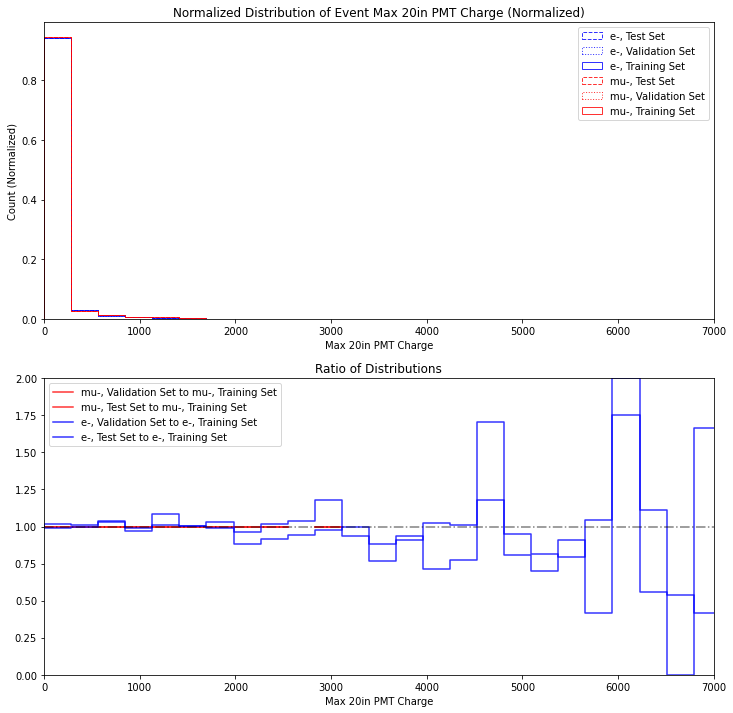

In [26]:
# e- and mu- 20in PMT max charges (include 0)
fig = plot_compare_dists([max_charge_20[train_mu_idxs], max_charge_20[train_mu_idxs], max_charge_20[train_mu_idxs],
                          max_charge_20[train_e_idxs], max_charge_20[val_e_idxs], max_charge_20[test_e_idxs]],
                          bins=30,
                          numerator_dist_idxs   = [1,2,4,5],
                          denominator_dist_idxs = [0,0,3,3],
                          labels= ['mu-, Training Set', 'mu-, Validation Set', 'mu-, Test Set',
                                   'e-, Training Set', 'e-, Validation Set', 'e-, Test Set'],
                          ratio_range=[0,2],
                          title='Normalized Distribution of Event Max 20in PMT Charge',
                          colors=['r','r','r','b','b','b'],
                          linestyle=['-',':','--','-',':','--'],
                          xlabel='Max 20in PMT Charge',
                          xrange=(0,7000),
                          verbose=True
                    )


Bins:  [   0.        61.37426  122.74852  184.12277  245.49704  306.8713
  368.24554  429.6198   490.99408  552.36835  613.7426   675.1169
  736.4911   797.86536  859.2396   920.6139   981.98816 1043.3624
 1104.7367  1166.111   1227.4852  1288.8595  1350.2338  1411.6079
 1472.9822  1534.3564  1595.7307  1657.105   1718.4792  1779.8535
 1841.2278 ]


/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/project/6008045/jgao/WatChMaL_analysis/tts_EDA/exploratory_dat

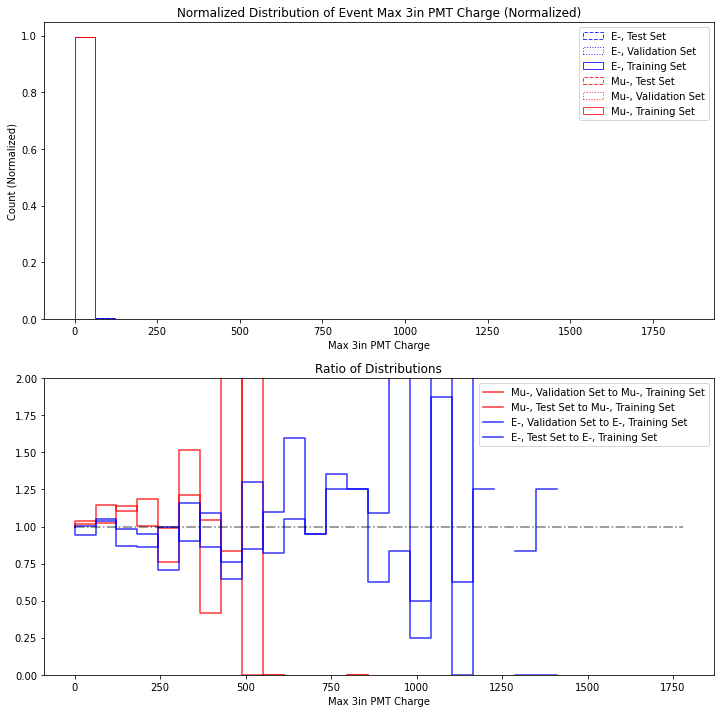

In [30]:
# e- and mu- 3in PMT max charges (include 0)
fig = plot_compare_dists([max_charge_3[train_mu_idxs], max_charge_3[val_mu_idxs], max_charge_3[test_mu_idxs],
                          max_charge_3[train_e_idxs], max_charge_3[val_e_idxs], max_charge_3[test_e_idxs]],
                          bins=30,
                          numerator_dist_idxs   = [1,2,4,5],
                          denominator_dist_idxs = [0,0,3,3],
                          labels= ['Mu-, Training Set', 'Mu-, Validation Set', 'Mu-, Test Set',
                                   'E-, Training Set', 'E-, Validation Set', 'E-, Test Set'],
                          ratio_range=[0,2],
                          title='Normalized Distribution of Event Max 3in PMT Charge',
                          colors=['r','r','r','b','b','b'],
                          linestyle=['-',':','--','-',':','--'],
                          xlabel='Max 3in PMT Charge',
                          verbose=True
                    )
